# TSP Estimations for UAV in Hostile Environment

In [83]:
import itertools
from random import seed
from random import randint
import pandas as pd
from tqdm import tqdm
from shapely.geometry import Point, Polygon
from typing import List, Dict, Union, Tuple
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import time
import math
import os
import pandas as pd
from heapq import nsmallest
from shapely.geometry import Point, Polygon, LineString

In [68]:
class Environment:
    def __init__(self, num_targets=10, num_no_entrances=10, num_threats=5, x_range=10_000, y_range=10_000,
                 seed_value=42) -> None:
        self._seed_value = seed_value
        seed(self._seed_value)

        # dimensions
        self._x_range = x_range
        self._y_range = y_range

        # entities and targets
        self._no_entrances = self._create_entities(num_no_entrances, (self._x_range / 100, self._x_range / 10))
        self._no_entrances_shapes = [ne['shape'] for ne in self._no_entrances]

        self._threats = self._create_entities(num_threats, (self._x_range / 10, self._x_range / 5))
        self._threats_shapes = [threat['shape'] for threat in self._threats]

        self._targets = [self.sample() for _ in range(num_targets)]
        self._targets_names = [f'({target.x},{target.y})' for target in self._targets]

    @property
    def x_range(self) -> int:
        return self._x_range

    @property
    def y_range(self) -> int:
        return self._y_range

    @property
    def no_entrances(self) -> List[Dict[str, Union[Point, float, Polygon]]]:
        return self._no_entrances

    @property
    def no_entrances_shapes(self) -> List[Polygon]:
        return self._no_entrances_shapes

    @property
    def threats(self) -> List[Dict[str, Union[Point, float, Polygon]]]:
        return self._threats

    @property
    def threats_shapes(self) -> List[Polygon]:
        return self._threats_shapes

    @property
    def targets(self) -> List[Point]:
        return self._targets

    @property
    def targets_names(self) -> List[str]:
        return self._targets_names

    def is_legal_point(self, point: Point) -> bool:
        for obstacle in self._no_entrances:
            if obstacle['shape'].contains(point):
                return False
        return True

    def is_legal_edge(self, p1: Point, p2: Point) -> bool:
        line = LineString([p1, p2])
        for ne in self._no_entrances_shapes:
            if line.intersects(ne):
                return False
        return True

    def _create_entities(self, num_entities: int, radius_range: Tuple[float, float]) -> List[Dict[str, Union[Point, float, Polygon]]]:
        entities_points = [Point(randint(0, self._x_range), randint(0, self._y_range)) for _ in range(num_entities)]

        rads = [randint(*radius_range) for _ in entities_points]

        return [{'center': point, 'radius': radius, 'shape': point.buffer(radius)} for point, radius in zip(entities_points, rads)]

    def sample(self) -> Point:
        rand_point = Point(randint(0, self._x_range), randint(0, self._y_range))
        while not self.is_legal_point(rand_point):
            rand_point = Point(randint(0, self._x_range), randint(0, self._y_range))
        return rand_point

    def plot(self) -> None:
        plt.figure(figsize=(10, 10))
        plt.title(f'environment of seed {self._seed_value}', fontsize=20)

        # plot no entrances
        for ne in self._no_entrances:
            X, Y = ne['shape'].exterior.xy
            plt.scatter(ne['center'].x, ne['center'].y, s=30, color='black', zorder=3)
            plt.scatter(ne['center'].x, ne['center'].y, s=20, color='blue', zorder=4)
            plt.plot(X, Y, color='blue')

        # plot threats
        for threat in self._threats:
            X, Y = threat['shape'].exterior.xy
            plt.scatter(threat['center'].x, threat['center'].y, s=30, color='black', zorder=3)
            plt.scatter(threat['center'].x, threat['center'].y, s=20, color='red', zorder=4)
            plt.plot(X, Y, color='red')

        # plot targets
        for target in self._targets:
            plt.scatter(target.x, target.y, color='black', zorder=9, s=100)
            plt.scatter(target.x, target.y, color='gold', zorder=10, s=80)

        # plot legend
        plt.legend(handles=[mpatches.Patch(color='gold', label=f'{len(self._targets)} targets'),
                            mpatches.Patch(color='blue', label=f'{len(self._no_entrances)} no entrance zones'),
                            mpatches.Patch(color='red', label=f'{len(self._threats)} threats')], ncol=3, loc='upper center')

In [69]:
class PRM:
    def __init__(self, env: Environment) -> None:
        self._env = env

        # neighborhood consts
        self._neighborhood_k = 10
        self._neighborhood_dist = 1000

        # init graph
        self._graph = nx.Graph()
        self._add_points(env.targets, is_target=True)

    @property
    def graph(self) -> nx.Graph():
        return self._graph

    def _add_points(self, points: List[Point], is_target: bool = False) -> None:
        for point in points:
            self._graph.add_node(f'({point.x},{point.y})', x=point.x, y=point.y, is_target=is_target)

    def _k_neighborhood(self, point: Point) -> List[Tuple[str, Dict]]:
        def _k_nearest_key(point_xy) -> float:
            _, xy = point_xy
            dist = (xy['x'] - point.x) ** 2 + (xy['y'] - point.y) ** 2
            return dist if dist > 0 else math.inf

        k_nearest_nodes = nsmallest(self._neighborhood_k, self._graph.nodes(data=True), key=_k_nearest_key)
        return k_nearest_nodes

    def _dist_neighborhood(self, point: Point) -> List[Tuple[str, Dict]]:
        neighborhood_nodes = []
        for node_name, xy in self._graph.nodes(data=True):
            dist = ((xy['x'] - point.x) ** 2 + (xy['y'] - point.y) ** 2) ** 0.5
            if dist < self._neighborhood_dist:
                neighborhood_nodes.append((node_name, xy))

        return neighborhood_nodes

    def add_samples(self, num_samples: int, neighborhood_type: str = 'k') -> None:
        samples = [self._env.sample() for _ in range(num_samples)]

        # add nodes to graph
        self._add_points(samples)

        # add legal edges to graph
        for sample in samples:
            self._perform_connections(sample, neighborhood_type)

    def _perform_connections(self, sample: Point, neighborhood_type: str) -> None:
        # add sample to graph
        sample_name = f'({sample.x},{sample.y})'
        self._graph.add_node(sample_name, x=sample.x, y=sample.y)

        # find near nodes to connect
        if neighborhood_type == 'k':
            near_nodes = self._k_neighborhood(sample)
        else:
            near_nodes = self._dist_neighborhood(sample)

        # add illegal edges with near group
        for node_name, node_data in near_nodes:
            x1, y1, x2, y2 = sample.x, sample.y, node_data['x'], node_data['y']
            if self._env.is_legal_edge(sample, Point(x2, y2)):
                weight = ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5
                self._graph.add_edge(sample_name, node_name, x1=x1, x2=x2, y1=y1, y2=y2, weight=weight)

    def plot(self) -> None:
        # plot environment
        self._env.plot()

        # plot roadmap
        plt.title(f'roadmap with {len(self._graph.nodes)} nodes and {len(self._graph.edges)} edges', fontsize=20)

        # plot edges
        for _, _, e_data in self._graph.edges(data=True):
            x1, x2, y1, y2 = e_data['x1'], e_data['x2'], e_data['y1'], e_data['y2']
            plt.plot([x1, x2], [y1, y2], color='green')

        # plot nodes
        for _, n_data in self._graph.nodes(data=True):
            x, y = n_data['x'], n_data['y']
            plt.scatter(x, y, color='black', s=60, zorder=7)
            plt.scatter(x, y, color='gray', s=50, zorder=8)

## environment and roadmap examples

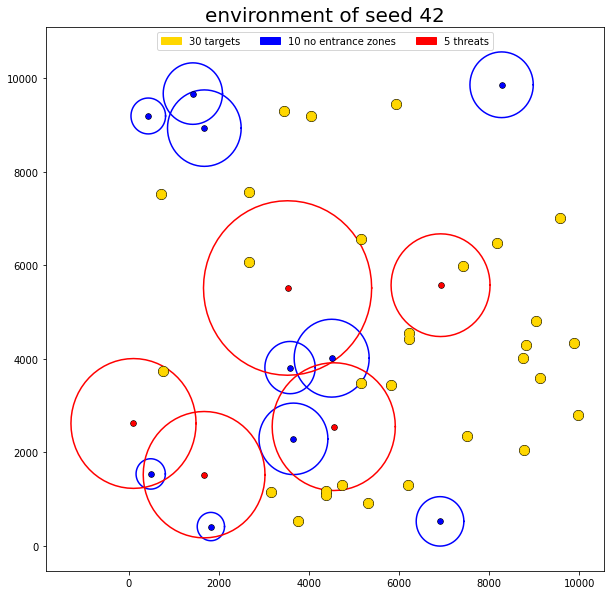

In [70]:
env = Environment(num_targets=30)
env.plot()

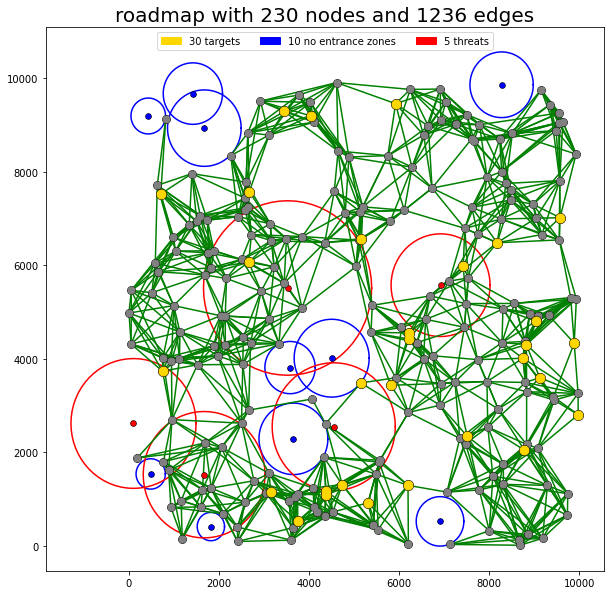

In [71]:
prm = PRM(env)
prm.add_samples(200, neighborhood_type='k')
prm.plot()
plt.show()

## distance computers

In [72]:
def single_source_distances(graph: nx.DiGraph, targets: List[Point]) -> Dict[Point, Dict[Point, float]]:
    distances = {t1: {t2: None for t2 in targets} for t1 in targets}

    for t in targets:
        from_target_distances = nx.single_source_dijkstra_path_length(source=t, G=graph, weight='weight')
        distances[t] = from_target_distances

    return distances

In [73]:
def all_source_distances(graph: nx.DiGraph, targets: List[Point]) -> Dict[Point, Dict[Point, float]]:
    _,from_targets_distances = nx.floyd_warshall_predecessor_and_distance(G=graph, weight='weight')
    distances = {t1: {t2: from_targets_distances[t1][t2] for t2 in targets} for t1 in targets}

    return distances

In [74]:
# sanity check
set(all_source_distances(prm.graph, env.targets_names)) == set(single_source_distances(prm.graph, env.targets_names))

True

## computation time comparison

In [90]:
nodes_amounts = list(range(100, 500, 100))
targets_fraction = 0.25

In [91]:
def write_distances_times(file_name: str, seed: float, num_nodes: int, num_edges: int, num_obstacles: int,
                          num_threats: int, num_targets: int, k: int, algorithm: str, computation_time: float) -> None:
    stats = [seed, num_nodes, num_edges, num_obstacles, num_threats, num_targets, k, algorithm, computation_time]

    if not os.path.exists(file_name):
        file = open(file_name, 'a+')
        file.write('seed,num_nodes,num_edges,num_obstacles,num_threats,num_targets,k,algorithm,computation_time\n')
    else:
        file = open(file_name, 'a+')

    file.write(",".join([str(s) for s in stats]))
    file.write('\n')

In [92]:
distance_computers = [single_source_distances, all_source_distances]
algorithms = ['dijkstra', 'floyd_warshall']

for distance_computer, algorithm in zip(distance_computers, algorithms):
    for nodes_amount in nodes_amounts:
        for seed_value in [42]:
            print(f'running {algorithm} for seed {seed_value} ..')
            env = Environment(num_targets=int(nodes_amount * targets_fraction))
            prm = PRM(env)
            prm.add_samples(nodes_amount, neighborhood_type='k')

            graph = prm.graph
            targets = env.targets_names
            print(f'graph has {len(graph.nodes)} nodes and {len(graph.edges)} edges')

            start = time.time()
            distances = distance_computer(graph, targets)
            elapsed_time = round(time.time() - start, 2)

            write_distances_times('distances_times.csv', seed_value, len(graph.nodes), len(graph.edges), len(env.no_entrances_shapes), len(env.threats), len(targets), prm._neighborhood_k, algorithm, elapsed_time)

running dijkstra for seed 42 ..
graph has 125 nodes and 644 edges
running dijkstra for seed 42 ..
graph has 250 nodes and 1288 edges
running dijkstra for seed 42 ..
graph has 375 nodes and 1969 edges
running dijkstra for seed 42 ..
graph has 500 nodes and 2636 edges
running floyd_warshall for seed 42 ..
graph has 125 nodes and 644 edges
running floyd_warshall for seed 42 ..
graph has 250 nodes and 1288 edges
running floyd_warshall for seed 42 ..
graph has 375 nodes and 1969 edges
running floyd_warshall for seed 42 ..
graph has 500 nodes and 2636 edges


In [102]:
distances_data = pd.read_csv('distances_times.csv')
distances_data.head()

,seed,num_nodes,num_edges,num_obstacles,num_threats,num_targets,k,algorithm,computation_time
0,42,125,644,10,5,25,10,dijkstra,0.05
1,42,250,1288,10,5,50,10,dijkstra,0.06
2,42,125,644,10,5,25,10,floyd_warshall,0.27
3,42,250,1288,10,5,50,10,floyd_warshall,2.16
4,42,125,644,10,5,25,10,dijkstra,0.02


In [104]:
dijkstra_data = distances_data[distances_data['algorithm'] == 'dijkstra']
dijkstra_data = dijkstra_data.groupby(['num_nodes', 'num_edges', 'num_obstacles', 'num_threats', 'num_targets', 'k'])['computation_time'].mean()

floyd_data = distances_data[distances_data['algorithm'] == 'floyd_warshall']
floyd_data = floyd_data.groupby(['num_nodes', 'num_edges', 'num_obstacles', 'num_threats', 'num_targets', 'k']).mean()

floyd_data.head()

,,,,,,seed,computation_time
num_nodes,num_edges,num_obstacles,num_threats,num_targets,k,,
125,644,10,5,25,10,42.0,0.250
250,1288,10,5,50,10,42.0,2.055
375,1969,10,5,75,10,42.0,6.830
500,2636,10,5,100,10,42.0,18.260


KeyError: 'num_nodes'

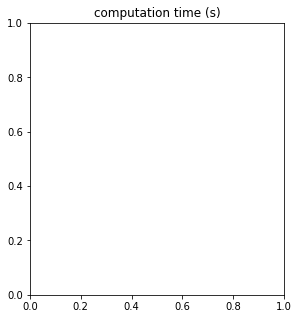

In [105]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('computation time (s)')
plt.plot(dijkstra_data['num_nodes'], dijkstra_data['computation_time'], label='dijkstra')
plt.plot(floyd_data['num_nodes'], floyd_data['computation_time'], label='floyd warshall')
plt.legend()

plt.subplot(1, 2, 1)
